In [1]:
#%% Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import spectral
import json

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

import annotation, image_render, hyspec_io, misc

In [2]:
# Paths
json_gray = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/label_classes.json'
#annotation_dir = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/Test_SampleAnnotations'
annotation_dir = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/OlbergAreaS'
hyspec_dir = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4_Rad_Georef_SGC'

In [3]:
# Find names of annotated images
ann_im_fullpath = misc.file_pattern_search(annotation_dir,'*.png')
print(ann_im_fullpath)

['/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/OlbergAreaS/OlbergholmenS_Pika_L_1-Radiance From Raw Data-Georectify Airborne Datacube.png', '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/OlbergAreaS/OlbergholmenS_Pika_L_10-Radiance From Raw Data-Georectify Airborne Datacube.png', '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/OlbergAreaS/OlbergholmenS_Pika_L_11-Radiance From Raw Data-Georectify Airborne Datacube.png', '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/OlbergAreaS/OlbergholmenS_Pika_L_12-Radiance From Raw Data-Georectify Airborne Datacube.png', '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_

In [4]:
# Extract filename base (common for hyspec and annotations files)
filenames = [os.path.splitext(os.path.basename(filepath))[0] for filepath in ann_im_fullpath]
for filename in filenames:
    print(filename)

OlbergholmenS_Pika_L_1-Radiance From Raw Data-Georectify Airborne Datacube
OlbergholmenS_Pika_L_10-Radiance From Raw Data-Georectify Airborne Datacube
OlbergholmenS_Pika_L_11-Radiance From Raw Data-Georectify Airborne Datacube
OlbergholmenS_Pika_L_12-Radiance From Raw Data-Georectify Airborne Datacube
OlbergholmenS_Pika_L_15-Radiance From Raw Data-Georectify Airborne Datacube
OlbergholmenS_Pika_L_16-Radiance From Raw Data-Georectify Airborne Datacube
OlbergholmenS_Pika_L_17-Radiance From Raw Data-Georectify Airborne Datacube
OlbergholmenS_Pika_L_18-Radiance From Raw Data-Georectify Airborne Datacube
OlbergholmenS_Pika_L_2-Radiance From Raw Data-Georectify Airborne Datacube
OlbergholmenS_Pika_L_23-Radiance From Raw Data-Georectify Airborne Datacube
OlbergholmenS_Pika_L_24-Radiance From Raw Data-Georectify Airborne Datacube
OlbergholmenS_Pika_L_8-Radiance From Raw Data-Georectify Airborne Datacube
OlbergholmenS_Pika_L_9-Radiance From Raw Data-Georectify Airborne Datacube


In [5]:
# Read annotation metadata file, show classes
class_dict = annotation.read_hasty_metadata(json_gray)
for class_name,class_ind in class_dict.items():
    print(class_name + ': ' + str(class_ind))

Sand: 1
Gravel: 2
Mud: 3
Terrestrial: 4
Zostera marina - dominant: 5
Zostera marina - normal: 6
Zostera marina - sparse: 7
Zostera marina with turf algae: 8
Turf algae - dominant: 9
Turf algae - normal: 10
Turf algae - sparse: 11
Rockweed: 12
Rockweed with turf algae: 13
Fucus serratus: 14
Aegagropila (algae ball): 15
Mixed algae classes on soft substrate: 16
Saccharina latissima: 17


In [6]:
# Loop through files and collect spectra for each class
data = []
for file in filenames:
    # Status update
    print('Processing file: ' + file)
    
    # Load hyperspectral file
    hyspec_file = os.path.join(hyspec_dir,file + '.bip.hdr')
    (im_cube,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(hyspec_file)
    
    # Create non-zero mask
    nonzero_mask = ~np.all(im_cube == 0,axis=2)
    
    # Open annotation file
    annotation_file = os.path.join(annotation_dir,file + '.png')
    annotation_mask = skimage.io.imread(annotation_file) * nonzero_mask
    
    # Create "local" dictionary for collecting data from current file
    data_dict = {'hyspec_file': hyspec_file, 
                 'annotation_file': annotation_file,
                 'nonzero_mask': nonzero_mask,
                 'annotation_mask': annotation_mask,
                 'spectra': []}  # Empty list, to be filled
    
    # Collect spectra for each class
    for (class_name,class_ind) in class_dict.items():
        spec = im_cube[annotation_mask == class_ind]
        data_dict['spectra'].append(spec)
    
    # Append dictionary to file list
    data.append(data_dict)
    

Processing file: OlbergholmenS_Pika_L_1-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_10-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_11-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_12-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_15-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_16-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_17-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_18-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_2-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_23-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_24-Radiance From Raw Data-Georecti

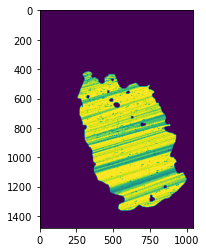

In [7]:
# Show example - annotation mask from file 2
plt.imshow(data[1]['annotation_mask'])
plt.show()

In [8]:
# Save to disk. Takes approx. 1.1 GB
np.save('/media/mha114/Massimal/Tmp/Test_Save_Collected_Spectra/test_save',data)

In [9]:
data.clear()
len(data)

0

In [10]:
data = np.load('/media/mha114/Massimal/Tmp/Test_Save_Collected_Spectra/test_save.npy',allow_pickle=True)

In [11]:
data[0]

{'hyspec_file': '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4_Rad_Georef_SGC/OlbergholmenS_Pika_L_1-Radiance From Raw Data-Georectify Airborne Datacube.bip.hdr',
 'annotation_file': '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/OlbergAreaS/OlbergholmenS_Pika_L_1-Radiance From Raw Data-Georectify Airborne Datacube.png',
 'nonzero_mask': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'annotation_mask': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0